In [12]:
!pip install geopandas

In [13]:
!pip install contextily
!pip install glob
!pip install matplotlib

ERROR: Could not find a version that satisfies the requirement glob (from versions: none)
ERROR: No matching distribution found for glob


In [14]:
import geopandas
import contextily
import backoff
import glob
import os

In [15]:
from maap.maap import MAAP
maap = MAAP(maap_host='api.maap-project.org')

def job_status_for(job_id: str) -> str:
    response = maap.getJobStatus(job_id)
    response.raise_for_status()
   
    root = ET.fromstring(response.text)
    status_element = root.find('.//{http://www.opengis.net/wps/2.0}Status')
   
    return status_element.text

def job_result_for(job_id: str) -> str:
    response = maap.getJobResult(job_id)
    response.raise_for_status()
   
    root = ET.fromstring(response.text)

    return root.find('.//{http://www.opengis.net/wps/2.0}Data').text

def to_job_output_dir(job_result_url: str) -> str:
    url_path = urlparse(job_result_url).path
    # The S3 Key is the URL path excluding the `/{username}` prefix
    s3_key = "/".join(url_path.split("/")[2:])

    return f"/projects/my-private-bucket/{s3_key}"

def wait_for_job(job_id: str) -> str:
    return job_status_for(job_id)

In [16]:
aoi = f"https://maap-ops-workspace.s3.amazonaws.com/shared/nehajo88/Data/NASA_CMS_2023/MEXICO/Example.geojson"

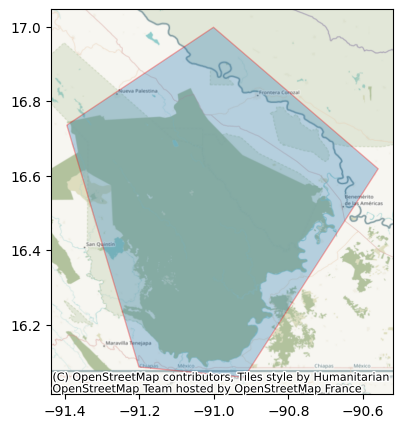

In [17]:
try:
    import geopandas as gpd
    import contextily as ctx
except:
    print(
        "If you wish to visually verify your AOI, "
        "you must install the `geopandas` and `contextily` packages."
    )
else:
    aoi_gdf = gpd.read_file(aoi)
    aoi_epsg4326 = aoi_gdf.to_crs(epsg=4326)
    ax = aoi_epsg4326.plot(figsize=(10, 5), alpha=0.3, edgecolor="red")
    ctx.add_basemap(ax, crs=4326)

In [11]:
#L4A Job for Only December 1, 2019- January 31,2020

In [18]:
inputs = dict(
    aoi=aoi,
    doi="L4A",
    lat="lat_lowestmode",
    lon="lon_lowestmode",
    beams="all",
    columns="agbd, agbd_se, sensitivity, geolocation/sensitivity_a2, elev_lowestmode",
    query="l2_quality_flag == 1 and l4_quality_flag == 1 and sensitivity > 0.95 and `geolocation/sensitivity_a2` > 0.95",
    limit=0,
    temporal="2019-12-01T00:00:00Z,2023-03-31T23:59:59Z",
    output="Mexico_gedi_subset_L4A_2019-2023.gpkg",
)

result = maap.submitJob(
    identifier="gedi-subset",
    algo_id="gedi-subset",
    version="0.6.2",
    queue="maap-dps-worker-32gb",
    username="nehajo88",
    **inputs,
)

job_id = result.id
job_id or result

'94697e4a-ebf8-4e1c-adf4-80280c1a4b52'

In [ ]:
job_id= 'ea93438b-47f3-4891-9f1a-75cbee9b599e'

from urllib.parse import urlparse


def job_status_for(job_id: str) -> str:
    return maap.getJobStatus(job_id)


def job_result_for(job_id: str) -> str:
    return maap.getJobResult(job_id)[0]


def to_job_output_dir(job_result_url: str) -> str:
    return f"/projects/my-private-bucket/{job_result_url.split(f'/{username}/')[1]}"

In [14]:
try:
    import backoff
except:
    job_status = job_status_for(job_id)
else:
    # Check job status every 2 minutes
    @backoff.on_predicate(
        backoff.constant,
        lambda status: status not in ["Deleted", "Succeeded", "Failed"],
        interval=120,
    )
    def wait_for_job(job_id: str) -> str:
        return job_status_for(job_id)

    job_status = wait_for_job(job_id)

job_status

'Succeeded'